In [1]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import MultiLabelBinarizer

## Preparation of the dataset

Drop all categorical columns and the rating columns, since we want to compare the clustering results with the rating.

In [3]:
df = pd.read_csv("results/train_clean.csv", index_col=0)

In [4]:
df['countryOfOrigin'] = df['countryOfOrigin'].apply(ast.literal_eval)
df['genres'] = df['genres'].apply(ast.literal_eval)

In [5]:
df['genres'][0][0]

'Action'

### Countries of Origin

We keep only the 4 most frequent countries of origin.

In [6]:
mbl = MultiLabelBinarizer()
countries_df = pd.DataFrame(mbl.fit_transform(df['countryOfOrigin']), columns=mbl.classes_, index=df.index)
countries_df = countries_df.astype('bool')
most_fr_countries = countries_df.sum().sort_values(ascending=False)
most_fr_countries.head(10)

US    7134
GB    1775
JP     846
FR     826
CA     621
IN     616
DE     502
IT     422
ES     325
AU     315
dtype: int64

In [7]:
countries_df = countries_df[most_fr_countries.head(4).index]
countries_df.head()

,US,GB,JP,FR
0,True,False,False,False
1,False,False,False,False
2,False,False,False,False
3,False,False,False,False
4,False,False,False,False


### Genres

We keep all genres.

In [8]:
genres_df = pd.DataFrame(mbl.fit_transform(df['genres']), columns=mbl.classes_, index=df.index)
genres_df = genres_df.astype('bool')
genres_df.sum().sort_values(ascending=False)

Drama          6175
Comedy         4839
Short          2464
Action         1957
Documentary    1835
Crime          1741
Adventure      1610
Animation      1487
Romance        1383
Family         1226
Thriller        785
Horror          688
Fantasy         656
Mystery         644
Music           554
Sci-Fi          449
Adult           433
Reality-TV      365
History         355
Talk-Show       338
Western         303
Biography       277
Game-Show       250
Sport           229
Musical         228
War             211
News            159
Film-Noir        27
dtype: int64

### Numeric columns

We drop the rating for the clustering

In [9]:
numeric_cols = df.dtypes[(df.dtypes == 'float64') | (df.dtypes == 'int64')].index
numeric_df = df[numeric_cols]
numeric_df.drop(['ratingNum'], axis=1, inplace=True)
numeric_df.head()

/tmp/ipykernel_31299/1867124789.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_df.drop(['ratingNum'], axis=1, inplace=True)


,startYear,runtimeMinutes,numVotes,totalImages,totalCredits,numRegions,numGenres,criticReviewsRatio
0,1995,3.713572,6.659294,0.693147,3.091042,0.693147,3,1.000000
1,1982,3.273393,2.484907,0.693147,0.693147,0.693147,1,0.000000
2,1992,4.510860,3.663562,0.693147,3.218876,0.693147,1,0.000000
3,2021,3.465736,2.772589,3.135494,4.043051,0.693147,1,0.000000
4,2020,4.394449,9.662625,5.852202,3.871201,3.496508,3,0.008772


### TitleType

In [10]:
title_df = pd.get_dummies(df['titleType'], columns=['titleType'], drop_first=True)
title_df.head()

,short,tvEpisode,tvMiniSeries,tvMovie,tvSeries,tvShort,tvSpecial,video,videoGame
0,False,True,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,True
2,False,False,False,False,False,False,False,False,False
3,False,False,False,False,True,False,False,False,False
4,False,False,False,False,True,False,False,False,False


### Boolean columns

In [11]:
bool_cols = df.dtypes[df.dtypes == 'bool'].index
bool_df = df[bool_cols]
bool_df.head()

,canHaveEpisodes,awardsAndNominations,hasVideos,moreCountriesOfOrigin
0,False,False,False,False
1,False,False,False,False
2,False,False,False,False
3,True,False,False,False
4,True,True,True,False


## Precompute distance matrix

We need to precompute a distance matrix in order to use also categorical variables.
We compute a distance matrix from the numeric columns using the euclidean distance after normalizing the features. We compute matrices for countries of origin, genres, title type and the original boolean columns using the jaccard distance.
We will obtain a final distance matrix summing the distances from all the matrices.

In [12]:
scaler = StandardScaler()
numeric_df = scaler.fit_transform(numeric_df)

In [13]:
distance_matrix = pdist(numeric_df, metric='euclidean')
del numeric_df
distance_matrix += pdist(bool_df, metric='jaccard')
del bool_df
# distance_matrix += pdist(countries_df, metric='jaccard')
del countries_df
# distance_matrix += pdist(genres_df, metric='jaccard')
del genres_df
# distance_matrix += pdist(title_df, metric='jaccard')
del title_df

In [14]:
distance_matrix = squareform(distance_matrix)

In [15]:
distance_matrix.shape

(16431, 16431)

## Clustering

In [16]:
def get_linkage_matrix(model):
    # Create linkage matrix

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    return linkage_matrix

def plot_dendrogram(model, **kwargs):
    linkage_matrix = get_linkage_matrix(model)
    dendrogram(linkage_matrix, **kwargs)

With the distance matrix given by the euclidean distance of numeric features and the jaccard distance of `canHaveEpisodes`, `awardsAndNominations`, `hasVideos` and `moreCountriesOfOrigin`, the best results are obtained with complete linkage.

In [17]:
hier_single = AgglomerativeClustering(distance_threshold=0,
                                      n_clusters=None,
                                      metric='precomputed',
                                      linkage='single')
hier_single.fit(distance_matrix)

AgglomerativeClustering(distance_threshold=0, linkage='single',
                        metric='precomputed', n_clusters=None)

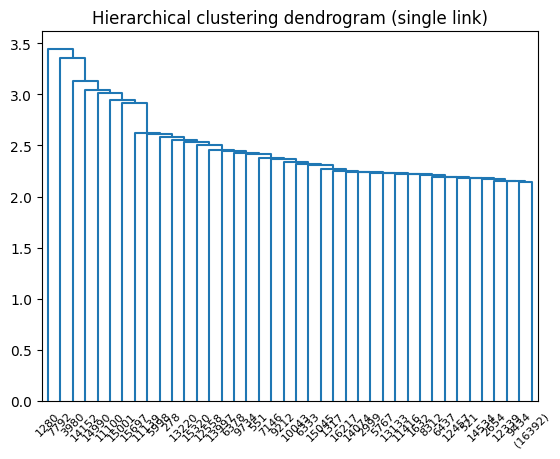

In [18]:
plt.title("Hierarchical clustering dendrogram (single link)")
plot_dendrogram(hier_single, truncate_mode="lastp", p=40,  color_threshold=0)
plt.show()

In [19]:
hier_average = AgglomerativeClustering(distance_threshold=0,
                                       n_clusters=None,
                                       metric='precomputed',
                                       linkage='average')
hier_average.fit(distance_matrix)

AgglomerativeClustering(distance_threshold=0, linkage='average',
                        metric='precomputed', n_clusters=None)

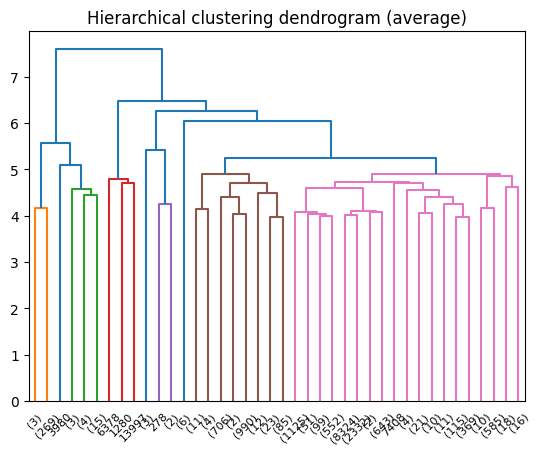

In [20]:
threshold = 5

plt.title("Hierarchical clustering dendrogram (average)")
plot_dendrogram(hier_average, truncate_mode="lastp", p=40,  color_threshold=threshold)
plt.show()

In [21]:
Z = get_linkage_matrix(hier_average)
labels = fcluster(Z, t=threshold, criterion='distance')
silhouette_score(distance_matrix, labels, metric='precomputed')

0.17993703099213434

In [22]:
np.unique(labels, return_counts=True)

(array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32),
 array([  272,    22,     1,     3,     3,     3,     6,  1833, 14288]))

Average linkage returns a very big cluster and several really small clusters.

In [23]:
df['c_average'] = labels

In [24]:
hier_complete = AgglomerativeClustering(distance_threshold=0,
                                n_clusters=None,
                                metric='precomputed',
                                linkage='complete')
hier_complete.fit(distance_matrix)

AgglomerativeClustering(distance_threshold=0, linkage='complete',
                        metric='precomputed', n_clusters=None)

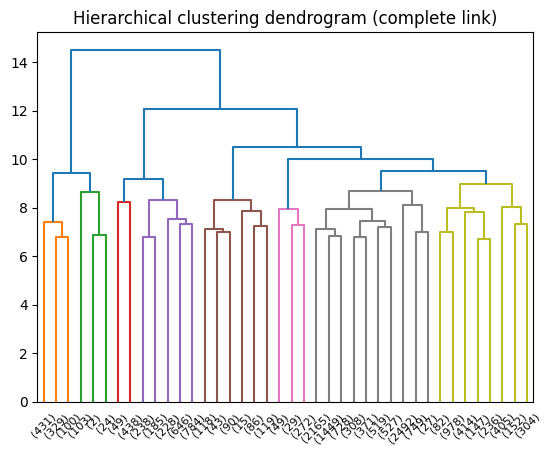

In [25]:
threshold = 9

plt.title("Hierarchical clustering dendrogram (complete link)")
plot_dendrogram(hier_complete, truncate_mode="lastp", p=40,  color_threshold=threshold)
plt.show()

In [26]:
Z = get_linkage_matrix(hier_complete)
labels = fcluster(Z, t=threshold, criterion='distance')
silhouette_score(distance_matrix, labels, metric='precomputed')

0.09318117310768989

In [27]:
np.unique(labels, return_counts=True)

(array([1, 2, 3, 4, 5, 6, 7, 8], dtype=int32),
 array([ 860,  129,  487, 2081,  471,  350, 9335, 2718]))

In [28]:
df['c_complete'] = labels

Text(0.5, 1.0, 'Clusters (average) against title type')

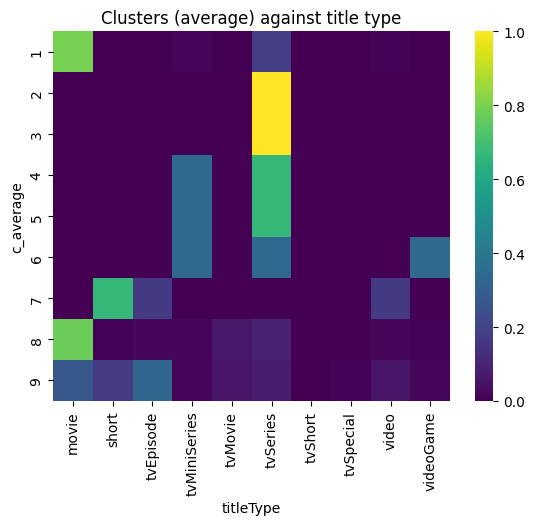

In [29]:
sns.heatmap(pd.crosstab(df['c_average'], df['titleType'],
                        normalize='index'),
                        cmap='viridis')
plt.title("Clusters (average) against title type")

Text(0.5, 1.0, 'Clusters (complete link) agains title type')

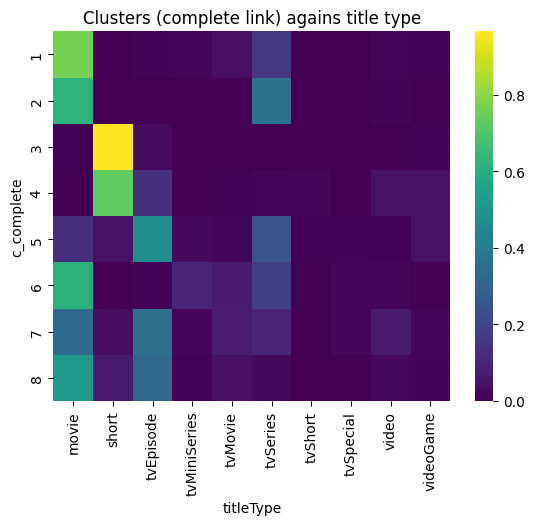

In [30]:
sns.heatmap(pd.crosstab(df['c_complete'], df['titleType'],
                        normalize='index'),
                        cmap='viridis'
                        )
plt.title("Clusters (complete link) agains title type")

In [31]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init='random', metric='precomputed')
reduced_df = pd.DataFrame(tsne.fit_transform(distance_matrix))

<Axes: xlabel='0', ylabel='1'>

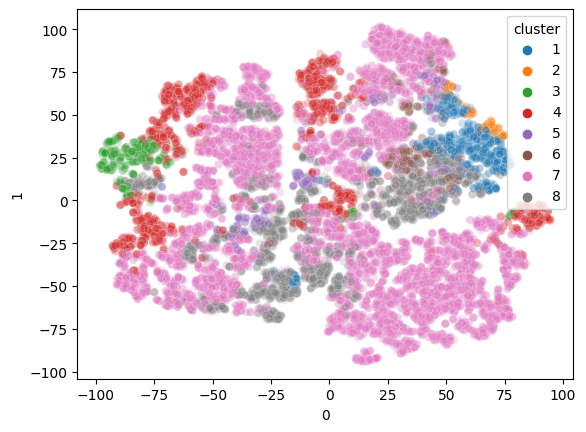

In [32]:
reduced_df['cluster'] = labels
sns.scatterplot(reduced_df, x=0, y=1, hue='cluster', palette='tab10', alpha=.2)